# Florian Guillot : Project 5
### Classify disaster tweets
### Jedha Full Stack, dsmf-paris-13
### 20-07-2021

The Dataset from Kaggle : [click here](https://www.kaggle.com/c/nlp-getting-started)

# **1) Initialization**
----
## **1.1) We begin with the Import of the different libraries we will use and their configurations**
----

In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.regularizers import L2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string

from itertools import product

#!pip install autocorrect
from autocorrect import Speller
import unidecode

from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

## **1.2) Data collection**
---

In [2]:
df_train= pd.read_csv('Data/train.csv')
df_test=pd.read_csv('Data/test.csv')

# **2) DEA**
---

## **2.1) Dataset Overview**
---

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


## **2.2) Handling missing values**
---

In [5]:
print('train shape : ',df_train.shape)
print('test shape : ',df_test.shape)

train shape :  (7613, 5)
test shape :  (3263, 4)


In [6]:
df_train.isnull().value_counts()

id     keyword  location  text   target
False  False    False     False  False     5080
                True      False  False     2472
       True     True      False  False       61
dtype: int64

### Both Keyword and location have missing values

## **2.3) Exploring the target**
---

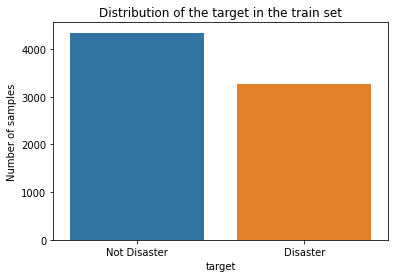

In [7]:
#Repartition of the target
plt.figure()
ax = sns.barplot(x = df_train.target.value_counts().index, y = df_train.target.value_counts())
ax.set (ylabel="Number of samples", 
        title ="Distribution of the target in the train set", 
        xlabel = "target",
        xticklabels = ['Not Disaster', 'Disaster'])
plt.show();

### The distribution is quite  balanced, there are more tweets without disaster (0) than with disaster (1)

## **2.4) Exploring features**
---

**Feature : the tweets**

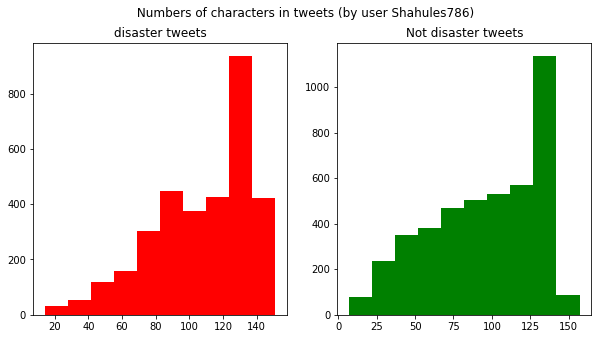

In [8]:
# tweets lenght
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
df_len=df_train[df_train['target']==1]['text'].str.len()
ax1.hist(df_len,color='red')
ax1.set_title('disaster tweets')
df_len=df_train[df_train['target']==0]['text'].str.len()
ax2.hist(df_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle(' Numbers of characters in tweets (by user Shahules786)')
plt.show()

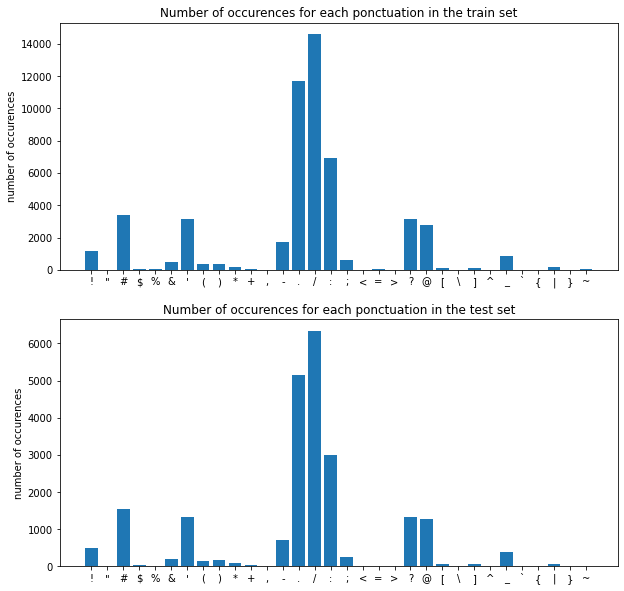

In [9]:
#Ponctuations occurence
ponctuations_train = {x : 0 for x in string.punctuation}
for ponc,text in product(string.punctuation, df_train['text']):
  ponctuations_train[ponc] += text.count(ponc) 
x_train,y_train=zip(*ponctuations_train.items())

ponctuations_test = {x : 0 for x in string.punctuation}
for ponc,text in product(string.punctuation, df_test['text']):
  ponctuations_test[ponc] += text.count(ponc) 
x_test,y_test=zip(*ponctuations_test.items())

fig = plt.figure(figsize=(10,10))

plt.subplot(211)
plt.ylabel("number of occurences")
plt.title("Number of occurences for each ponctuation in the train set")
plt.bar(x_train,y_train)

plt.subplot(212)
plt.ylabel("number of occurences")
plt.title("Number of occurences for each ponctuation in the test set")
plt.bar(x_test,y_test)

plt.show();

**Feature :  Location**

In [13]:
print("Occurence of each locations :")
df_train['location'].value_counts()

Occurence of each locations :


USA                    104
New York                71
United States           50
London                  45
Canada                  29
                      ... 
MontrÌ©al, QuÌ©bec       1
Montreal                 1
ÌÏT: 6.4682,3.18287      1
Live4Heed??              1
Lincoln                  1
Name: location, Length: 3341, dtype: int64

### There are 3000+ locations but most appears only one time. We won't use this feature

**Feature :  Keywords**

In [14]:
print("Occurence of each keyword:")
df_train['keyword'].value_counts()

Occurence of each keyword:


fatalities               45
deluge                   42
armageddon               42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

### **There are 221 keywords in the train set, we are not sure we will have those keywords in the test set. We won't use keywords as a feature but will add them in the tweets as simple words. To ensure our thoughts we are going to see the repartition of keywords regarding the target:**

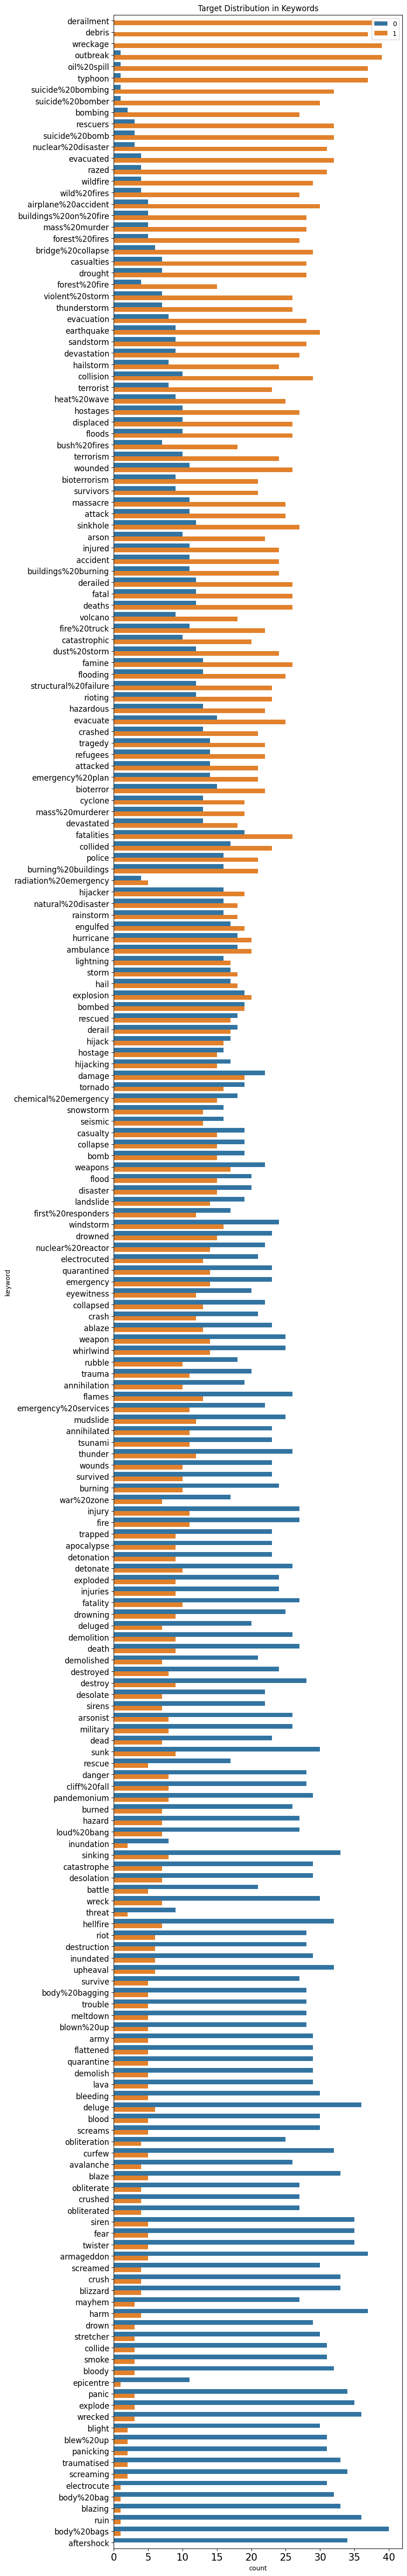

In [100]:
fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

### **Keywords add understanding, we think that our approach is a good idea**

# **3) Data Cleaning**
---

## **3.1) Cleaning function**
---

We will use one function to treat all the tweets. When we will encounter an issue we will add the cleaning in this function. This functions has been built iteratively

In [101]:
spell = Speller(lang='en') # The speller function we use

def clean (tweet, spell):

  # Transform Upper case in lower case
  tweet = tweet.lower()

  # Deletes urls
  tweet = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", tweet)
        
  # Delete the @xxxxxx when the tweetos tags another account
  tweet = re.sub(r"@\w+", "", tweet)

  # We delete punctuations and special characters :
  for p in string.punctuation:
      tweet = tweet.replace(p, f' {p} ') #we choose to add spaces around punctuations
      tweet = tweet.replace(p,'') # and delete them 
      
  # We delete accentuations
  tweet = unidecode.unidecode(tweet)

  # We delete the one-letter-word
  tweet = ' '.join( [w for w in tweet.split() if (len(w)>1) | (w == 'i')] )
      
  # Transform ... and .. by ' ... '
  tweet = tweet.replace('...', ' ... ')
  if '...' not in tweet:
      tweet = tweet.replace('..', ' ... ') 

  #Misspelling:
  tweet = spell(tweet)
  
  #Transform multiples spaces in one space
  tweet = re.sub(r"\s{2,}", " ", tweet)

  return tweet

We clean data and test

In [102]:
%time df_train['text_1cleaned'] = df_train['text'].apply(lambda s : clean(s, spell))
%time df_test['text_1cleaned'] = df_test['text'].apply(lambda s : clean(s, spell))

Wall time: 6min 43s
Wall time: 2min 59s


## **3.2) Adding the keywords in the text**
---

In [103]:
df_train['text_cleaned'] = df_train['keyword'].apply(lambda x: str(x).replace('%20', ' ')) + ' ' +  df_train['text_1cleaned'] #With that we keep the word 'nan' who indicates the tweets without keyword
df_train.drop(columns = ['text_1cleaned'], axis=1, inplace = True)
df_test['text_cleaned'] = df_test['keyword'].apply(lambda x: str(x).replace('%20', ' ')) + ' ' + df_test['text_1cleaned']
df_test.drop(columns = ['text_1cleaned'], axis=1, inplace=True)


## **3.3) Results of the text transformation**
---

In [104]:
df_train.head()

,id,keyword,location,text,target,text_cleaned
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,nan our deeds are the reason of this earthquak...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,nan forest fire near la range task canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,nan all residents asked to shelter in place ar...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,nan 13 000 people receive wildfires evacuation...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,nan just got sent this photo from ruby alaska ...


In [105]:

print('Before preprocessing : ', df_train.text[1250])
print('After preprocessing : ',df_train.text_cleaned[1250])

Before preprocessing :  So my band Buildings on Fire are playing @bbcintroducing @PurpleTurtleRdg this Wednesday with @GIANTGIANTSOUND https://t.co/ofaN6DkOEZ #rdg
After preprocessing :  buildings on fire so my band buildings on fire are playing this wednesday with rd


# **4) Preprocessing**
---

## **4.1) Preprocessing with Lemma_**
---

In [106]:
import en_core_web_sm
nlp = en_core_web_sm.load()

## Import stop words from spacy 
from spacy.lang.en.stop_words import STOP_WORDS

## Tokenize the train and the test
token_train = df_train['text_cleaned'].fillna('').apply(lambda x: nlp(x))
token_test = df_test['text_cleaned'].fillna('').apply(lambda x: nlp(x))

# Remove stop-words
token_train = token_train.apply(lambda x: [token.lemma_ for token in x if (token.lemma_ not in STOP_WORDS) or (token.text not in STOP_WORDS)])
token_test = token_test.apply(lambda x: [token.lemma_ for token in x if (token.lemma_ not in STOP_WORDS) or (token.text not in STOP_WORDS)])

# Add a clean token column 
df_train["clean_token"] = [" ".join(x) for x in token_train]
df_test["clean_token"] = [" ".join(x) for x in token_test]

# spaCy has a slightly annoying lemma (recall that lemma is the output of lemmatization): -PRON-. This is used as the lemma for all pronouns such as Their, you, me, and I.  Other NLP tools lemmatize these to I instead of a placeholder, such as -PRON-.
df_train["clean_token"] = df_train["clean_token"].str.replace('-PRON-','i')
df_test["clean_token"] = df_test["clean_token"].str.replace('-PRON-','i')


Let's look at the results:

In [107]:
df_train.head()

,id,keyword,location,text,target,text_cleaned,clean_token
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,nan our deeds are the reason of this earthquak...,nan deed reason earthquake alla forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,nan forest fire near la range task canada,nan forest fire near la range task canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,nan all residents asked to shelter in place ar...,nan resident ask shelter place notify officer ...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,nan 13 000 people receive wildfires evacuation...,nan 13 000 people receive wildfire evacuation ...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,nan just got sent this photo from ruby alaska ...,nan got send photo ruby alaska smoke wildfire ...


In [108]:
df_test.head()

,id,keyword,location,text,text_cleaned,clean_token
0,0,NaN,NaN,Just happened a terrible car crash,nan just happened terrible car crash,nan happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",nan heard about earthquake is different cities...,nan hear earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",nan there is forest fire at spot pond geese ar...,nan forest fire spot pond geese flee street I ...
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,nan apocalypse lighting spoken wildfires,nan apocalypse lighting speak wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,nan typhoon soudelor kills 28 in china and taiwan,nan typhoon soudelor kill 28 china taiwan


We use workcloud to have a vizualization of our results

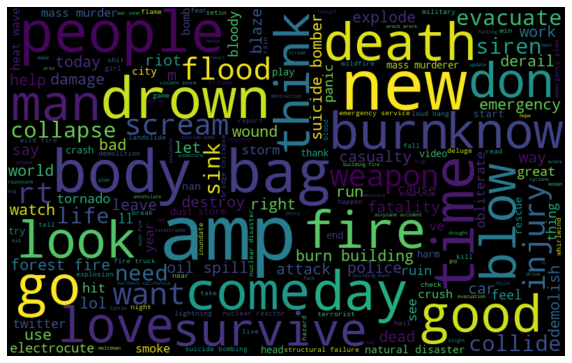

In [109]:
from wordcloud import WordCloud 
all_word = ' '.join([text for text in df_train['clean_token']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_word) 
plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off') 
plt.show()

## **4.2) Tokenizing and Padding**
---

We load the data into a batch generator

In [110]:
#We create a tokenizer object that fits on both train and test
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train["clean_token"])

In [111]:
#top 20 apparitions count in our tokens
print(sorted(list(tokenizer.word_counts.values()), reverse = True)[0:20])

[2154, 583, 398, 344, 318, 306, 300, 264, 263, 241, 238, 236, 235, 233, 226, 220, 219, 204, 204, 201]


We launch the tokenization and the padding

In [112]:
df_train["indices"] = tokenizer.texts_to_sequences(df_train["clean_token"])
df_test["indices"] = tokenizer.texts_to_sequences(df_test["clean_token"])
#We shuffle the dataset 
df_train = df_train.sample(df_train.shape[0])

In [113]:
df_train.head()

,id,keyword,location,text,target,text_cleaned,clean_token,indices
2102,3019,death,NaN,RSS: Judge orders Texas to recognize spouse on...,0,death rss judge orders texas to recognize spou...,death rss judge order texas recognize spouse s...,"[22, 6840, 1861, 359, 699, 2354, 6841, 863, 22..."
4252,6041,heat%20wave,NaN,Apocalpytic Iran Heat Wave Nearly Breaks World...,1,heat wave apocalyptic iran heat wave nearly br...,heat wave apocalyptic iran heat wave nearly br...,"[135, 87, 2394, 418, 135, 87, 675, 199, 81, 742]"
1956,2817,cyclone,NaN,@XHNews We need these plants in the pacific du...,1,cyclone we need these plants in the pacific du...,cyclone need plant pacific cyclone season help,"[254, 97, 1164, 1996, 254, 835, 104]"
703,1015,blazing,Everywhere,**Let - Me - Be - Your - Hot - Blazing - Fanta...,0,blazing let me be your hot blazing fantasy esc...,blaze let I hot blazing fantasy escort gf dubai,"[67, 101, 1, 211, 5821, 1410, 5822, 2136, 5823]"
5923,8455,screamed,"Charlotte, North Carolina",I thought the loudest goal I ever screamed was...,0,screamed i thought the oldest goal i ever stre...,scream I think old goal I stream higuain offsi...,"[24, 1, 63, 89, 1437, 1, 332, 9569, 9570, 1437..."


In [114]:
max_len = max ( max([len(x) for x in df_train.indices]), max([len(x) for x in df_test.indices]) ) 
print ("In test and train, we have maximum",max_len,"tokens","in one tweet")

In test and train, we have maximum 23 tokens in one tweet


We launch the padding

In [115]:
padded_train_indices =pad_sequences(df_train.indices, padding="post",maxlen=max_len)
padded_test_indices = pad_sequences(df_test.indices, padding="post",maxlen=max_len)

In [116]:
print('shape of ou train:', padded_train_indices.shape)
print('shape of ou test:', padded_test_indices.shape)

shape of ou train: (7613, 23)
shape of ou test: (3263, 23)


## **4.3) Creating the tensorflow dataset**
---

In [117]:
# Creation of the tensorFlow dataset : tf_ds
tf_ds = tf.data.Dataset.from_tensor_slices((padded_train_indices,df_train.target))

In [118]:
#Let's take a look to our tensors
X_tensor, Y_tensor = next(iter(tf_ds))
print(X_tensor)
print(Y_tensor)

tf.Tensor(
[  22 6840 1861  359  699 2354 6841  863   22 3385    0    0    0    0
    0    0    0    0    0    0    0    0    0], shape=(23,), dtype=int32)
tf.Tensor(0, shape=(), dtype=int64)


In [119]:
# Shuffle & Batch
BATCH_SIZE = 64
vocab_size = len(tokenizer.word_index)

## **4.4) Separating train data and test data in the train dataset**
---


In [120]:
# Train Test Split
TAKE_SIZE = int(0.7*len(df_train)) #70% data taken for training, 30% for test

train_data = tf_ds.take(TAKE_SIZE)
test_data = tf_ds.skip(TAKE_SIZE)

train_data = train_data.shuffle(TAKE_SIZE).batch(BATCH_SIZE)
test_data = test_data.shuffle(len(tf_ds) - TAKE_SIZE).batch(BATCH_SIZE)

# **5) Building models**
---
 (the conclusion of our tries is : we will use model 1/4 to enter the competition)

## **5.1) Model LSTM**
---

In [121]:
model1 = tf.keras.Sequential([
                  # Input Word Embedding layer        
                  tf.keras.layers.Embedding(vocab_size+1, 64, mask_zero=True, input_shape=[max_len,]),

                  tf.keras.layers.BatchNormalization(),

                  # LSTM Bidirectionnal new layer
                  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False)),

                  # We create noise with dropout
                  tf.keras.layers.Dropout(.2),              

                  tf.keras.layers.Dense(128, activation = 'relu'),

                  tf.keras.layers.Dense(64, activation = 'relu'),

                  tf.keras.layers.Dense(32, activation = 'relu'),

                  tf.keras.layers.Flatten(),

                  tf.keras.layers.Dense(1, activation = 'sigmoid')
])
model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 23, 64)            683200    
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               197632    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2

## **5.2) Model with only dense, BatchNormalization and dropout**
---

In [122]:
model2 = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size+1, 64, mask_zero=True, input_shape=[max_len,]),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(256, activation='sigmoid'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 23, 64)            683200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 64)            256       
_________________________________________________________________
dense_4 (Dense)              (None, 23, 512)           33280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 512)           0         
_________________________________________________________________
dense_5 (Dense)              (None, 23, 256)           131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 23, 256)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5888)             

## **5.3) Model 3 with Bidirectional LSTM and multiple dropout**
---

In [123]:
l2 = L2(l2=0.01)

model3 = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_size+1, 64, mask_zero=True, input_shape=[max_len,]),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.4, return_sequences=True,  kernel_regularizer=l2)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.4, return_sequences=False, kernel_regularizer=l2)),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 23, 64)            683200    
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 64)            256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 23, 64)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 23, 256)           197632    
_________________________________________________________________
dropout_4 (Dropout)          (None, 23, 256)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164352    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)              

## **5.4) Model Conv1D**
---

In [124]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 64, mask_zero=True, input_shape=[max_len,]),
    tf.keras.layers.Conv1D(140, 3, activation='relu', strides=1),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 23, 64)            683200    
_________________________________________________________________
conv1d (Conv1D)              (None, 21, 140)           27020     
_________________________________________________________________
global_average_pooling1d (Gl (None, 140)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 140)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               72192     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 513       
Total params: 782,925
Trainable params: 782,925
Non-trainable params: 0
________________________________________________

We create a learning rate schedule because our first tries overfitted

In [125]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# We need to define the initial learning rate, decay_steps indicates the number
# of steps before the learning rate decreases of one time the decay_rate.
ed = ExponentialDecay(
    initial_learning_rate = 0.001, decay_steps = 100, decay_rate = 0.96
)

# **6) Training model 1**
---

In [126]:
model = model1

## **6.1) Building a function to follow our metric f1**
---

In [128]:
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
  

## **6.2) Compiling the model**
---

Using a simple compiler with an Adam optimizer to compute our gradients, we add our learning rate schedule

In [130]:
optimizer= tf.keras.optimizers.Adam(learning_rate=ed)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),  f1_metric])

## **6.3) Fitting the model with our data**
---

Application of the model

In [131]:
history = model.fit(train_data,
                    validation_data=test_data,
                    epochs=10)

Epoch 1/10
84/84 [==============================] - 8s 47ms/step - loss: 0.0402 - binary_accuracy: 0.9809 - f1_metric: 0.9778 - val_loss: 1.5873 - val_binary_accuracy: 0.7539 - val_f1_metric: 0.6870
Epoch 2/10
84/84 [==============================] - 2s 27ms/step - loss: 0.0468 - binary_accuracy: 0.9803 - f1_metric: 0.9767 - val_loss: 1.3900 - val_binary_accuracy: 0.7487 - val_f1_metric: 0.6976
Epoch 3/10
84/84 [==============================] - 2s 28ms/step - loss: 0.0366 - binary_accuracy: 0.9842 - f1_metric: 0.9816 - val_loss: 1.3586 - val_binary_accuracy: 0.7601 - val_f1_metric: 0.7017
Epoch 4/10
84/84 [==============================] - 2s 27ms/step - loss: 0.0284 - binary_accuracy: 0.9842 - f1_metric: 0.9815 - val_loss: 1.6366 - val_binary_accuracy: 0.7504 - val_f1_metric: 0.6997
Epoch 5/10
84/84 [==============================] - 2s 27ms/step - loss: 0.0253 - binary_accuracy: 0.9867 - f1_metric: 0.9844 - val_loss: 1.4745 - val_binary_accuracy: 0.7518 - val_f1_metric: 0.6936
Epoch

## **6.4) Assessing performance**
---

In [132]:
#Loss
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.show()
history.history['val_binary_accuracy']
#-----------------------

#Accuracy
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["binary_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_binary_accuracy"],
                          name="Validation accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Accuracy'    
)
fig.show()

#-----------------------

# F1 score
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["f1_metric"],
                          name="Training f1",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_f1_metric"],
                          name="Validation f1",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val f1_score across epochs',
    xaxis_title='epochs',
    yaxis_title='f1'    
)
fig.show()

![cell_132_1](figures/cell_132_1.PNG)

![cell_132_2](figures/cell_132_2.PNG)

![cell_132_3](figures/cell_132_3.PNG)

We build a y_test_pred with a specific slider

In [133]:
y_test_pred = [ 0 if x[0] < 0.3 else 1 for x in model.predict(test_data).tolist() ] #0.3 is the slider
X_test = list(map(lambda x: x[0].numpy(), test_data.unbatch()))
y_test = list(map(lambda x: x[1].numpy(), test_data.unbatch()))

We generate a dataframe with the results of the prediction. We focus on the misspredicted tweets

In [134]:
df_results = pd.DataFrame({'tweet' : tokenizer.sequences_to_texts(X_test), 'target' : y_test, 'prediction' : y_test_pred})

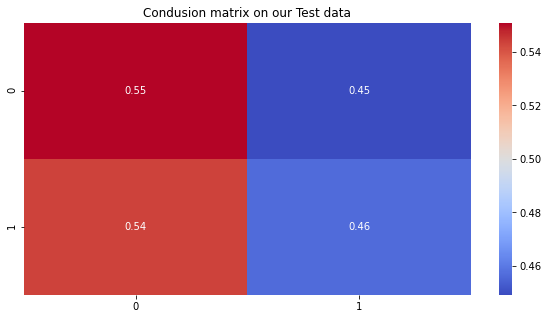

In [135]:
from sklearn.metrics import confusion_matrix, f1_score
cm_test = confusion_matrix(df_results.target, df_results.prediction, normalize = 'true')
plt.figure(figsize=(10,5))
sns.heatmap(cm_test, annot= True, cmap= 'coolwarm').set_title('Condusion matrix on our Test data')
plt.plot();

### We can see that we have more false positive than false negative. It means our model predicts too much disaster-tweet. As the main goal is to be alerted of a disaster, we change the slider of this unbalanced result, and put it at positive is percentage > 0.3 and not 0.5 as we prefer to be 'alerted' for nothing

In [136]:
print("f1-score on test set with a slider at 0.3 : ", f1_score(y_test, y_test_pred))

f1-score on test set with a slider at 0.3 :  0.4365841334007074


In [137]:
results = df_results[df_results.target != df_results.prediction]
print("The results dataframe's shape: ",results.shape)
results.head()

The results dataframe's shape:  (1115, 3)


,tweet,target,prediction
4,fatal 11 year old boy charge manslaughter todd...,0,1
5,body bag women buckle casual stylish shoulder ...,1,0
6,crush cell hear hope dream crush,1,0
7,wreckage australia news rt janeenorman high pr...,0,1
9,storm finally storm,0,1


# **7) Entering the competition**
---

## **7.1) Re-training the model one with all the datas** 
---

In [138]:
model_final = model1

model_final.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),  f1_metric])

history_final = model_final.fit(tf_ds.shuffle(len(tf_ds)).batch(BATCH_SIZE),
                    epochs=4)

Epoch 1/4
119/119 [==============================] - 8s 25ms/step - loss: 0.2474 - binary_accuracy: 0.9149 - f1_metric: 0.8978
Epoch 2/4
119/119 [==============================] - 3s 27ms/step - loss: 0.0875 - binary_accuracy: 0.9670 - f1_metric: 0.9616
Epoch 3/4
119/119 [==============================] - 3s 26ms/step - loss: 0.0521 - binary_accuracy: 0.9771 - f1_metric: 0.9723
Epoch 4/4
119/119 [==============================] - 3s 26ms/step - loss: 0.0409 - binary_accuracy: 0.9807 - f1_metric: 0.9770


Puting the results in a file as asked by Kaggle

In [139]:
sample_sub= pd.read_csv('Data/sample_submission.csv')

y_pred = model_final.predict(padded_test_indices)
y_pred = np.round(y_pred).astype(int).reshape(len(df_test))
sub = pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pred})
sub.to_csv('submission.csv',index=False)

## **7.2) Result of the competition**
---

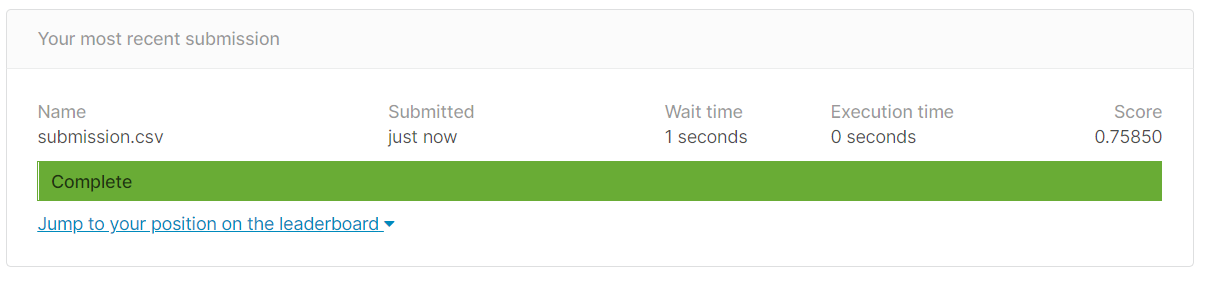